# Multiclass Classification Metrics
> Multiclass classification metrics with torchmetrics, highlighting the difference between micro and macro metrics.

- toc: true 
- badges: true
- comments: true
- categories: [pytorch, torchmetrics, classification]

In my last [post]({% post_url 2022-8-17-pet_breed_classification %}) I showed how to use torchmetrics to implement classification metrics for the Oxford-IIIT pet dataset. We saw that the `average` keyword had to be set to `micro` for accuracy and `macro` for the $F1$ score, so that the metrics were consistent with scikit-learn. In this post, I'll delve deeper into these keywords, and how they affect the metrics in question. In a following post, I'll also discuss `mdmc_average`, which is relevant for multiclass image segmentation.

First note that this keyword isn't relevant for binary classifiers. For binary classifiers, there is only one way to calculate precision, recall, $F1$ score, etc. Calculate the *confusion matrix*, i.e. true positives, false positives, false negatives, and true negatives, and then use [formulas based on these quantities](https://en.wikipedia.org/wiki/Confusion_matrix). For multi-class classification, the situation is slightly more complicated.

The examples below will look primarily at accuracy and precision, but note that precision can be replaced by recall, f1 score, jaccard index, etc.

In [ ]:
!pip install pytorch-lightning
!pip install seaborn

In [21]:
import torch
import sklearn 

# Set the seed for reproduciblity.
torch.manual_seed(7)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

To better understand the metrics, we'll work with a $4$ class problem with $n = 100$ samples. Classes $0$ and $3$ will have a probability of occurence of $\frac{1}{15}$, class $1$ will have a probability of $\frac{2}{3}$, and class $2$ will have a probability of $\frac{1}{5}$. We can generate data having this distribution using `torch.multinomial` below.

In [5]:
weights = torch.tensor([1, 10, 3, 1], dtype=torch.float)
num_classes = len(weights)
shape = (100,)
size = shape[0]
output = torch.multinomial(weights, size, replacement=True)
target = torch.multinomial(weights, size, replacement=True)

For example, the output looks like:

In [6]:
output

tensor([1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 0, 0, 1, 0, 1, 2, 0, 3, 1, 3, 2, 2, 1, 1,
        2, 1, 3, 2, 1, 3, 1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1,
        1, 2, 0, 1, 1, 2, 1, 2, 3, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 2, 3, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 1, 1])

For our purposes, it'll be more convienent to work with one hot encoded data.

In [7]:
output_oh = torch.zeros(size, num_classes)
output_oh[torch.arange(size), output] = 1
target_oh = torch.zeros(size, num_classes)
target_oh[torch.arange(size), target] = 1

Then the first $10$ samples of the output looks like:

In [8]:
output_oh[:10]

tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])

### Micro statistics

After the one hot encoding, the output and target tensors each have shape $[N, C]$, in contrast with binary classification data which has shape $[N]$. Due to this multidimensionality, there are at least two ways to compute the confusion matrix.
For the first way, we calculate the confusion matrix of each sample over all classes:

In [10]:
from torchmetrics.classification import StatScores

# Use reduce="samples" to calculate the confusion matrix per sample.
stat_scores = StatScores(num_classes=num_classes, reduce="samples")
stats = stat_scores(output_oh, target)
tp, fp, tn, fn, _ = stats[:, 0], stats[:, 1], stats[:, 2], stats[:, 3], stats[:, 4]

For example for the first $3$ samples, the confusion matricies are:

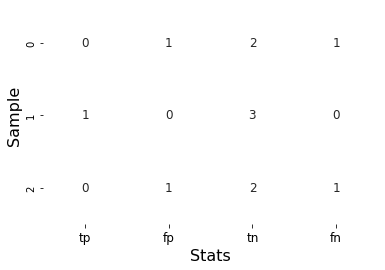

In [11]:
ax = sns.heatmap(torch.vstack([tp[:3], fp[:3], tn[:3], fn[:3]]).T.numpy(),annot=True,
                 annot_kws={"fontsize":12},linewidths=2, cbar=False,cmap=ListedColormap(['white']))
ax.set_xlabel("Stats", fontsize=16)
ax.set_ylabel("Sample", fontsize=16)
ax.set_xticklabels(["tp", "fp", "tn", "fn"], fontsize=12)
plt.show()

The confusion matrix for the entire classifier is then obtained by summing over the samples:

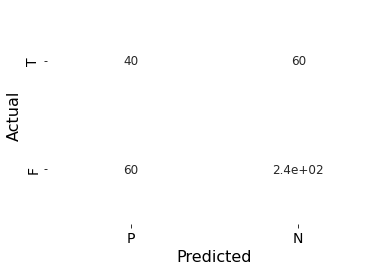

In [12]:
ax = sns.heatmap(torch.tensor([[tp.sum(), fn.sum()], [fp.sum(), tn.sum()]]).numpy(),annot=True,
                 annot_kws={"fontsize":12},linewidths=2, cbar=False,cmap=ListedColormap(['white']))
ax.set_xlabel("Predicted", fontsize=16)
ax.set_ylabel("Actual", fontsize=16)
ax.set_yticklabels(["T", "F"], fontsize=14)
ax.set_xticklabels(["P", "N"], fontsize=14)
plt.show()

We could've also reached the above answer using:

In [14]:
stat_scores = StatScores(num_classes=num_classes, reduce="micro")
stats = stat_scores(output_oh, target)
stats[:4]

tensor([ 40,  60, 240,  60])

From which various metrics like accuracy, precision, and recall can be calculated. When these metrics are calculated this way, the averaging technique is called **micro**. <br/>
For example, the accuracy, i.e. the number of correctly classified samples divided by the total samples, is

In [15]:
((tp.sum())/(tp.sum()+fn.sum())).item()

0.4000000059604645

Similarly, using `torchmetrics` we get

In [16]:
from torchmetrics.functional.classification import accuracy

accuracy(output_oh, target,num_classes=num_classes,average="micro").item()

0.4000000059604645

Which is precisely what `scikit-learn` calculates:

In [43]:
sklearn.metrics.accuracy_score(target, output)

0.4

Since the false positive and false negative counts are always the same, all other metrics like precision and recall <br/>
are the same as accuracy. For example the precision is

In [28]:
((tp.sum())/(tp.sum()+fp.sum())).item()

0.4000000059604645

Similarly, using `torchmetrics` we have:

In [29]:
from torchmetrics.functional.classification import precision

precision(output_oh, target,num_classes=num_classes,average="micro").item()

0.4000000059604645

This is why **micro** statistics are rarely mentioned, because they don't give rise to new metrics.

### Macro statistics

The second way to calculate the confusion matrix is to calculate the statistics for each class separately over all samples.

In [30]:
stat_scores = StatScores(num_classes=num_classes, reduce="macro")
stats = stat_scores(output_oh, target)
tp, fp, tn, fn, _ = stats[:,0], stats[:, 1], stats[:, 2], stats[:, 3], stats[:, 4]

which gives the confusion matricies for classes $0$, $1$,...,$3$.

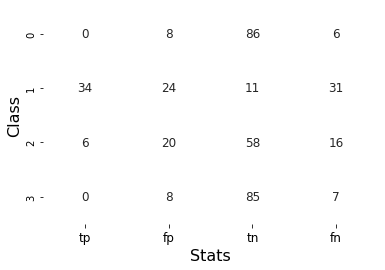

In [31]:
ax = sns.heatmap(torch.vstack([tp, fp, tn, fn]).T.numpy(),annot=True,
                 annot_kws={"fontsize":12},linewidths=2, cbar=False,cmap=ListedColormap(['white']))
ax.set_xlabel("Stats", fontsize=16)
ax.set_ylabel("Class", fontsize=16)
ax.set_xticklabels(["tp", "fp", "tn", "fn"], fontsize=12)
plt.show()

From which various metrics like precision, and recall can be calculated by calculating the metric for each class and then averaging. When these metrics are calculated this way, the averaging technique is called **macro**. <br/>
For example, the precision, is

In [32]:
(tp/(tp + fp)).mean().item()

0.20424403250217438

Similarly, using `torchmetrics` we have:

In [38]:
from torchmetrics.functional.classification import precision

precision(output,target,num_classes=num_classes,average="macro").item()

0.20424403250217438

which is the same as `scikit-learn`:

In [42]:
# Note that scikit-learn takes the target as the first argument instead
# of the second.
sklearn.metrics.precision_score(target, output,average="macro")

0.2042440318302387

Finally, it's important to note that class $1$ is much more probable than the others, hence its precision score should be weighted differently than the others. In other words, when working with an **imbalanced** dataset like this one, it makes sense to use a weighted average:

In [47]:
precision(output,target,num_classes=num_classes,average="weighted").item()

0.43180373311042786

Which clearly paints a different picture of the quality of the predictions.